# Parse Trajectory Information

In [1]:
import urllib.request,json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
print ("Packages loaded.")

Packages loaded.


### Parse json

In [2]:
page_link = 'http://sparklingmesh.iptime.org:10000/api/v1/position/list?id=1'
with urllib.request.urlopen(page_link) as url:
    s = url.read()
    json_parsed = json.loads(s)
traj = json_parsed['data']
L = len(traj)
print ("L:[%d]"%(L))    

L:[575]


### Parse time-stamped trajectory

In [7]:
xy_traj = np.zeros(shape=(L,2))
times = np.zeros(shape=(L))
for tick in range(L):
    p_t = traj[tick]
    x,y,sec_org = p_t['rX'],p_t['rY'],p_t['timestamp']/1000
    if tick == 0:
        sec_init = sec_org
    sec = sec_org - sec_init
    xy_traj[tick,0],xy_traj[tick,1],times[tick] = x,y,sec
    print ("tick:[%d] sec:[%.2f] xy:(%.2f,%.2f)"%(tick,sec,x,y)) # print

tick:[0] sec:[0.00] xy:(18.13,10.59)
tick:[1] sec:[0.00] xy:(18.13,10.59)
tick:[2] sec:[0.00] xy:(18.13,10.59)
tick:[3] sec:[0.72] xy:(17.33,9.79)
tick:[4] sec:[0.72] xy:(17.33,9.79)
tick:[5] sec:[1.72] xy:(16.43,8.89)
tick:[6] sec:[2.72] xy:(16.23,8.96)
tick:[7] sec:[2.72] xy:(16.23,8.96)
tick:[8] sec:[2.72] xy:(16.23,8.96)
tick:[9] sec:[3.72] xy:(16.29,8.26)
tick:[10] sec:[3.72] xy:(16.29,8.26)
tick:[11] sec:[4.72] xy:(15.29,7.76)
tick:[12] sec:[4.72] xy:(15.29,7.76)
tick:[13] sec:[5.72] xy:(14.39,7.56)
tick:[14] sec:[5.72] xy:(14.39,7.56)
tick:[15] sec:[6.72] xy:(14.59,6.56)
tick:[16] sec:[6.72] xy:(14.59,6.56)
tick:[17] sec:[7.72] xy:(14.56,5.66)
tick:[18] sec:[8.72] xy:(14.66,4.66)
tick:[19] sec:[8.72] xy:(14.66,4.66)
tick:[20] sec:[8.72] xy:(14.66,4.66)
tick:[21] sec:[9.72] xy:(13.66,5.66)
tick:[22] sec:[9.72] xy:(13.66,5.66)
tick:[23] sec:[10.72] xy:(14.56,4.76)
tick:[24] sec:[10.72] xy:(14.56,4.76)
tick:[25] sec:[11.72] xy:(14.66,4.72)
tick:[26] sec:[11.72] xy:(14.66,4.72)
tick

### Plot trajectory

In [13]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath
def colorline(
    x, y, z=None, cmap=plt.get_cmap('jet'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
    z = np.asarray(z)
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)
    ax = plt.gca()
    ax.add_collection(lc)
    return lc
def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments
print ("Done.")

Done.


### Plot trajectory

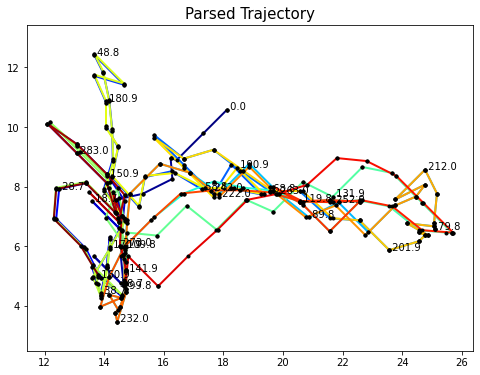

In [20]:
plt.figure(figsize=(8,6))
plt.plot(xy_traj[:,0],xy_traj[:,1],'ko',markersize=3)
colorline(xy_traj[:,0],xy_traj[:,1],np.linspace(0,1,L),linewidth=2)
for tick in range(L):
    if (tick%20) == 0:
        plt.text(xy_traj[tick,0],xy_traj[tick,1],
                 ' %.1f'%times[tick],fontsize=10)
plt.title('Parsed Trajectory',fontsize=15)
plt.axis('equal')
plt.show()

### Make heatmap

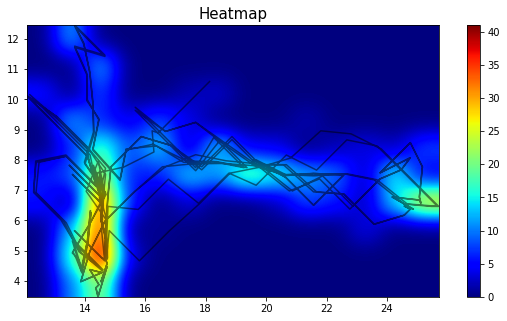

In [26]:
from matplotlib import cm
heatmap,xedges,yedges = np.histogram2d(xy_traj[:,0],xy_traj[:,1], bins=(14,10))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure(figsize=(10,5))
plt.plot(xy_traj[:,0],xy_traj[:,1],'k-',alpha=0.5)
plt.imshow(heatmap.T,extent=extent,origin='lower',cmap=cm.jet,
          interpolation='gaussian')
plt.colorbar()
plt.title('Heatmap',fontsize=15)
plt.show()

### Kalman Filter

In [27]:
class KalmanFilterClass(object):
    def __init__(self,name='kf',dt=0.05,q_x=0.1,q_v=0.1,r_y=1.0,y_init=0.0):
        self.name = name
        self.dt = dt
        self.q_x = q_x
        self.q_v = q_v
        self.r_y = r_y
        self.y_init = y_init
        # Initialize some internal variables
        self.Q = np.array([[self.q_x,0],[0,self.q_v]])
        self.R = np.array(self.r_y)
        self.H = np.array([[1,0]])
        self.F = np.array([[1,self.dt],[0,1]])
        #
        self.x_hat = np.array([[self.y_init],[0]])
        self.P_hat = self.Q
        self.y = self.y_init
        
    # Update Kalman Filter
    def update(self,y):
        x_hat_m = np.matmul(self.F,self.x_hat)
        P_hat_m = np.matmul(np.matmul(self.F,self.P_hat),self.F.T) + self.Q
        W = np.linalg.inv(np.matmul(np.matmul(self.H,P_hat_m),self.H.T)+self.R)
        K = np.matmul(np.matmul(P_hat_m, self.H.T),W)
        # Update
        self.x_hat = self.x_hat + np.matmul(K,y-np.matmul(self.H,x_hat_m))
        self.P_hat = P_hat_m - np.matmul(np.matmul(K,self.H),P_hat_m)
print ("Done.")

Done.


Filtered


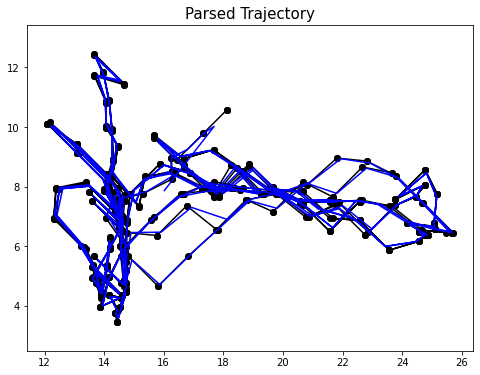

In [29]:
# Kalman filtering 
dt,q_x,q_v,r_y = 0.25,1.0,0.5,2.0
K_x = KalmanFilterClass(
    name='x',dt=dt,q_x=q_x,q_v=q_v,r_y=r_y,y_init=xy_traj[tick,0])
K_y = KalmanFilterClass(
    name='y',dt=dt,q_x=q_x,q_v=q_v,r_y=r_y,y_init=xy_traj[tick,1])
xy_traj_filtered = np.zeros(shape=(L,2))
for tick in range(L):
    # Kalman filter
    K_x.update(y=xy_traj[tick,0])
    K_y.update(y=xy_traj[tick,1])
    # Use predicted position
    x_filtered = K_x.x_hat[0] + K_x.x_hat[1]*K_x.dt
    y_filtered = K_y.x_hat[0] + K_y.x_hat[1]*K_y.dt
    xy_traj_filtered[tick,0],xy_traj_filtered[tick,1] = x_filtered,y_filtered
print ("Filtered")

# - Plot - 
plt.figure(figsize=(8,6))
plt.plot(xy_traj[:,0],xy_traj[:,1],'ko-')
plt.plot(xy_traj_filtered[:,0],xy_traj_filtered[:,1],'b-')
plt.axis('equal')
plt.title('Parsed Trajectory',fontsize=15)
plt.show()

### Make features

==== Booth visit frequency feature ====
	Booth[0]	Booth[1]	Booth[2]	Booth[3]	Booth[4]	
<1.0m 	 0.18    	 0.10    	 0.00    	 0.06    	 0.03    	
<2.0m 	 0.29    	 0.25    	 0.01    	 0.17    	 0.14    	
<3.0m 	 0.39    	 0.44    	 0.17    	 0.35    	 0.26    	
<4.0m 	 0.47    	 0.63    	 0.27    	 0.55    	 0.30    	


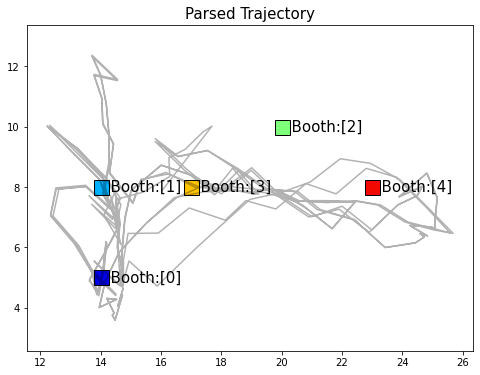

In [104]:
np.set_printoptions(precision=2)
# Set booth locations
booth_xys = np.array([[14,5],[14,8],[20,10],[17,8],[23,8]])

# Distance thresholds
d_ths = [1,2,3,4]

# Loop
n_booth = booth_xys.shape[0] # number of booths
n_th = len(d_ths) # number of thresholds

feature = np.zeros(shape=(n_booth,n_th)) # feature

for tick in range(L): # for all ticks
    xy_t = xy_traj_filtered[tick] 
    for b_idx in range(n_booth): # for all booths 
        booth_xy_b = booth_xys[b_idx]
        dist_b = np.linalg.norm(xy_t-booth_xy_b) # distance to booth
        for d_idx in range(n_th): # for different distance thresholds
            d_th = d_ths[d_idx]
            if dist_b < d_th:
                feature[b_idx,d_idx] = feature[b_idx,d_idx] + 1
        VERBOSE = False
        if VERBOSE:
            print ("tick:[%d] b_idx:[%d] xy_t:%s booth_xy:%s dist_b:[%.2f]"%
                   (tick,b_idx,xy_t,booth_xy_b,dist_b))
# Normalize
feature = feature / L

# Printout feature information
print ("==== Booth visit frequency feature ====")
print ("\t",end= '')
for b_idx in range(n_booth):
    print ("Booth[%d]\t"%(b_idx),end= '')
print ("")
for d_idx in range(n_th):    
    d_th = d_ths[d_idx]
    print ("<%.1fm \t"%(d_th),end= '')
    for b_idx in range(n_booth):
        freq = feature[b_idx,d_idx]
        print (" %.2f    \t"%(freq),end= '')
    print ("") 
    
# Plot trajectory with booths
plt.figure(figsize=(8,6))
colors = plt.cm.jet(np.linspace(0.1,0.9,n_booth))
for b_idx in range(n_booth):
    color = colors[b_idx]
    plt.plot(booth_xys[b_idx,0],booth_xys[b_idx,1],marker='s',
             color='k',mfc=color,ms=15,lw=5)
    plt.text(booth_xys[b_idx,0],booth_xys[b_idx,1],
             '  Booth:[%d]'%(b_idx),fontsize=15,va='center')
plt.plot(xy_traj_filtered[:,0],xy_traj_filtered[:,1],'k-',alpha=0.3)
plt.axis('equal')
plt.title('Parsed Trajectory',fontsize=15)
plt.show()